In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from sklearn.preprocessing import MinMaxScaler

In [10]:

# Step 1: Generate base sine wave
np.random.seed(42)
timesteps = 1000
time = np.arange(timesteps)
signal = np.sin(0.02 * time)  # smooth sine wave

# Step 2: Add small Gaussian noise
noise = np.random.normal(0, 0.05, size=timesteps)
sensor_data = signal + noise

# Step 3: Inject anomalies (spikes or drops)
anomaly_indices = np.random.choice(timesteps, size=20, replace=False)
sensor_data[anomaly_indices] += np.random.choice([3, -3], size=20)  # large deviation

# Step 4: Build DataFrame
df = pd.DataFrame({
    "time": time,
    "value": sensor_data
})
df["anomaly"] = 0
df.loc[anomaly_indices, "anomaly"] = 1

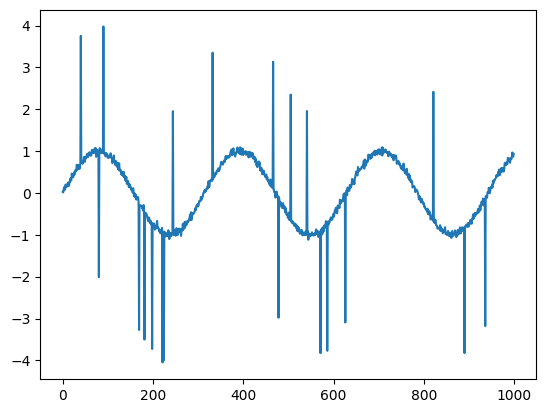

In [11]:
plt.plot(df['time'], df['value'])

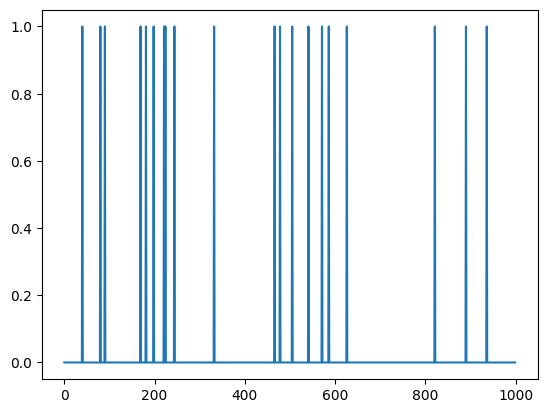

In [12]:
plt.plot(df['time'], df['anomaly'])

In [13]:
class AutoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size = 5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, (h_t, c_t) = self.lstm(x)
        last_hidden = h_t[-1]
        y = self.fc(last_hidden)
        return y

In [14]:
series_length = 30
X = []
y = []

sc = MinMaxScaler()
df['value_norm'] = sc.fit_transform(df['value'].to_numpy().reshape(-1,1))
for i in range(len(df['value']) - series_length):
    X.append(df.iloc[i:i+series_length]['value_norm'].tolist())
    y.append(df.iloc[i+series_length]['value_norm'])

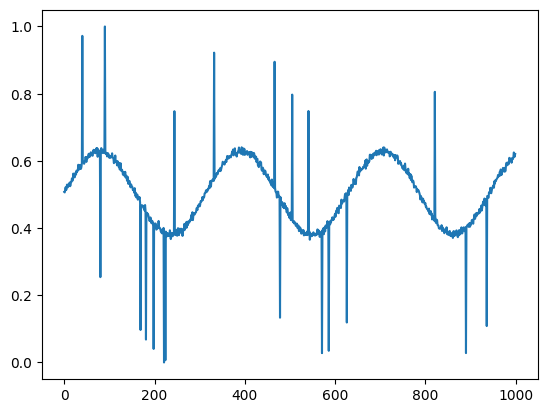

In [15]:
plt.plot(df['value_norm'])

In [16]:
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype = torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype = torch.float32).unsqueeze(-1)

batch_size, seq_size, input_size = X_tensor.shape
X_tensor.shape

torch.Size([970, 30, 1])

In [17]:
model = AutoLSTM(input_size = input_size, hidden_size = 5)

In [18]:
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr = learning_rate)



In [19]:
epochs = 30

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(batch_size):
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(X_tensor[i])
        y_true = y_tensor[i]
        
        loss = loss_fn(y_pred, y_true)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss
    
    print(f"Epoch: {epoch + 1}, loss: {total_loss}")


Epoch: 1, loss: 18.23740005493164
Epoch: 2, loss: 11.419644355773926
Epoch: 3, loss: 11.211503028869629
Epoch: 4, loss: 11.16744327545166
Epoch: 5, loss: 11.135083198547363
Epoch: 6, loss: 11.10422134399414
Epoch: 7, loss: 11.073822975158691
Epoch: 8, loss: 11.043740272521973
Epoch: 9, loss: 11.013951301574707
Epoch: 10, loss: 10.984400749206543
Epoch: 11, loss: 10.955168724060059
Epoch: 12, loss: 10.926107406616211
Epoch: 13, loss: 10.89732551574707
Epoch: 14, loss: 10.868734359741211
Epoch: 15, loss: 10.840350151062012
Epoch: 16, loss: 10.812178611755371
Epoch: 17, loss: 10.784152030944824
Epoch: 18, loss: 10.756308555603027
Epoch: 19, loss: 10.728619575500488
Epoch: 20, loss: 10.701037406921387
Epoch: 21, loss: 10.67362117767334
Epoch: 22, loss: 10.646286964416504
Epoch: 23, loss: 10.619077682495117
Epoch: 24, loss: 10.591959953308105
Epoch: 25, loss: 10.564906120300293
Epoch: 26, loss: 10.537949562072754
Epoch: 27, loss: 10.511040687561035
Epoch: 28, loss: 10.484186172485352
Epoch:

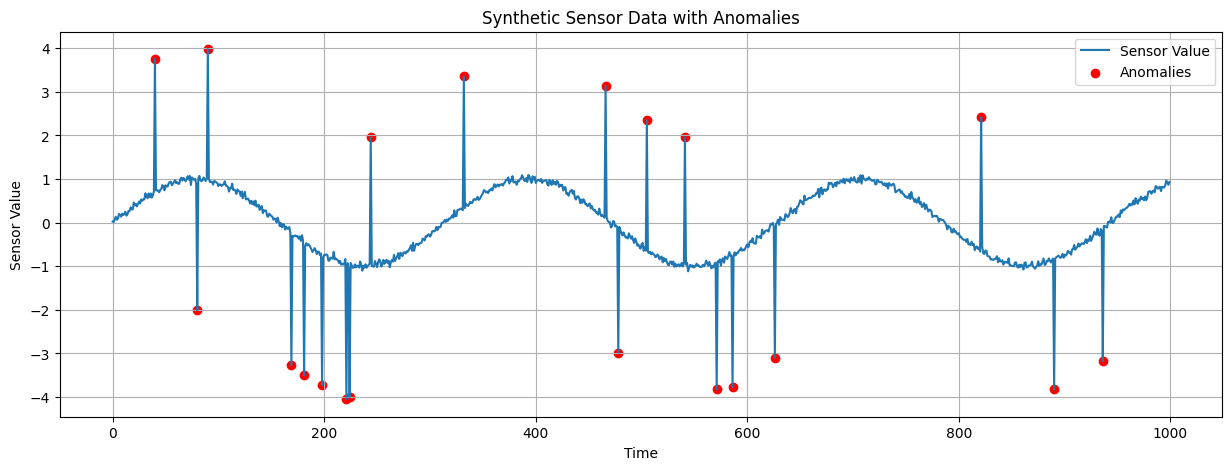

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(df["time"], df["value"], label="Sensor Value")
plt.scatter(df[df["anomaly"] == 1]["time"],
            df[df["anomaly"] == 1]["value"],
            color='red', label="Anomalies")
plt.title("Synthetic Sensor Data with Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model.eval()
true_val = []
pred_val = []

with torch.no_grad():
    for i in range(batch_size):
        y_pred = model(X_tensor[i])
        pred_val.append(y_pred)
        y_true = y_tensor[i]
        true_val.append(y_true)
        print(y_pred, y_true)
        
true_val = np.array(true_val)
pred_val = np.array(pred_val)
    

tensor([0.5004]) tensor([0.5711])
tensor([0.5004]) tensor([0.5884])
tensor([0.5006]) tensor([0.5788])
tensor([0.5006]) tensor([0.5743])
tensor([0.5005]) tensor([0.5879])
tensor([0.5006]) tensor([0.5771])
tensor([0.5005]) tensor([0.5879])
tensor([0.5006]) tensor([0.5763])
tensor([0.5005]) tensor([0.5820])
tensor([0.5005]) tensor([0.5933])
tensor([0.5007]) tensor([0.9721])
tensor([0.5080]) tensor([0.5966])
tensor([0.5026]) tensor([0.5965])
tensor([0.5013]) tensor([0.5970])
tensor([0.5009]) tensor([0.5913])
tensor([0.5007]) tensor([0.5976])
tensor([0.5007]) tensor([0.6007])
tensor([0.5008]) tensor([0.6117])
tensor([0.5010]) tensor([0.6087])
tensor([0.5011]) tensor([0.5969])
tensor([0.5009]) tensor([0.6113])
tensor([0.5011]) tensor([0.6082])
tensor([0.5011]) tensor([0.6077])
tensor([0.5010]) tensor([0.6169])
tensor([0.5012]) tensor([0.6208])
tensor([0.5013]) tensor([0.6213])
tensor([0.5013]) tensor([0.6114])
tensor([0.5012]) tensor([0.6157])
tensor([0.5012]) tensor([0.6207])
tensor([0.5013

tensor([0.4974]) tensor([0.3756])
tensor([0.4974]) tensor([0.3839])
tensor([0.4976]) tensor([0.3789])
tensor([0.4976]) tensor([0.3823])
tensor([0.4977]) tensor([0.3762])
tensor([0.4977]) tensor([0.3805])
tensor([0.4977]) tensor([0.3790])
tensor([0.4977]) tensor([0.3874])
tensor([0.4978]) tensor([0.3818])
tensor([0.4978]) tensor([0.3825])
tensor([0.4978]) tensor([0.3781])
tensor([0.4977]) tensor([0.3779])
tensor([0.4977]) tensor([0.3786])
tensor([0.4977]) tensor([0.3841])
tensor([0.4978]) tensor([0.3794])
tensor([0.4978]) tensor([0.3844])
tensor([0.4978]) tensor([0.3960])
tensor([0.4980]) tensor([0.3891])
tensor([0.4979]) tensor([0.3823])
tensor([0.4978]) tensor([0.3924])
tensor([0.4979]) tensor([0.3831])
tensor([0.4978]) tensor([0.3738])
tensor([0.4977]) tensor([0.3810])
tensor([0.4977]) tensor([0.3765])
tensor([0.4977]) tensor([0.3869])
tensor([0.4978]) tensor([0.3901])
tensor([0.4979]) tensor([0.0278])
tensor([0.4946]) tensor([0.3941])
tensor([0.4977]) tensor([0.3918])
tensor([0.4983

tensor([0.4987]) tensor([0.4645])
tensor([0.4987]) tensor([0.4587])
tensor([0.4986]) tensor([0.4565])
tensor([0.4985]) tensor([0.4550])
tensor([0.4985]) tensor([0.4560])
tensor([0.4986]) tensor([0.4494])
tensor([0.4985]) tensor([0.4579])
tensor([0.4986]) tensor([0.4423])
tensor([0.4984]) tensor([0.4445])
tensor([0.4984]) tensor([0.4407])
tensor([0.4984]) tensor([0.4503])
tensor([0.4985]) tensor([0.4404])
tensor([0.4984]) tensor([0.4435])
tensor([0.4984]) tensor([0.4257])
tensor([0.4982]) tensor([0.4346])
tensor([0.4983]) tensor([0.4365])
tensor([0.4983]) tensor([0.4294])
tensor([0.4982]) tensor([0.4336])
tensor([0.4983]) tensor([0.4218])
tensor([0.4982]) tensor([0.8055])
tensor([0.5042]) tensor([0.4356])
tensor([0.4995]) tensor([0.4172])
tensor([0.4982]) tensor([0.4148])
tensor([0.4979]) tensor([0.4249])
tensor([0.4980]) tensor([0.4240])
tensor([0.4980]) tensor([0.4092])
tensor([0.4979]) tensor([0.4081])
tensor([0.4979]) tensor([0.4074])
tensor([0.4979]) tensor([0.3992])
tensor([0.4978

In [23]:
abs_value = np.abs(pred_val - true_val)

In [24]:
abs_value.mean()

0.08514305

In [28]:
percentile_95 = np.percentile(abs_value, 95)
ind, val = np.where(abs_value > percentile_95 + abs_value.mean())
found_indexes = ind + 30
found_indexes

array([ 40,  80,  90, 169, 181, 198, 221, 224, 244, 332, 466, 478, 505,
       541, 571, 586, 626, 821, 890, 936])

In [29]:
defined_anomaly = df[df['anomaly'] == 1]['time'].to_numpy()
defined_anomaly

array([ 40,  80,  90, 169, 181, 198, 221, 224, 244, 332, 466, 478, 505,
       541, 571, 586, 626, 821, 890, 936])

In [36]:
correct_found = np.intersect1d(defined_anomaly, found_indexes)
accurancy = len(correct_found) / len(defined_anomaly) * 100
print(f"Founding accuracy is: {accurancy}")

Founding accuracy is: 100.0


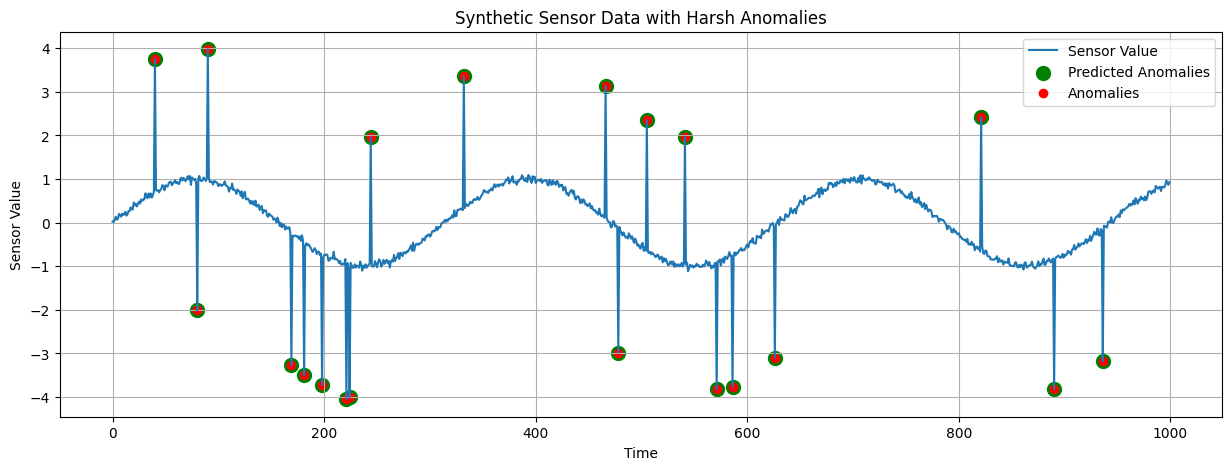

In [84]:
plt.figure(figsize=(15, 5))
plt.plot(df["time"], df["value"], label="Sensor Value")
plt.scatter( found_indexes, df.loc[df['time'].isin(found_indexes), ['value']], color='green', label='Predicted Anomalies', s = 100)

plt.scatter(df[df["anomaly"] == 1]["time"],
            df[df["anomaly"] == 1]["value"],
            color='red', label="Anomalies")

plt.title("Synthetic Sensor Data with Harsh Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()